In [1]:
import joblib
from wordcloud import WordCloud

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
import numpy as np
import pandas as pd
import datetime

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import time

In [2]:
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cpu")
device

device(type='cpu')

### 1. Functions

In [4]:
def create_dataset(tokenizer, max_len, labels_data, tweets_data):
    input_ids = []
    attention_masks = []

    for tweet in tweets_data:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels_data)
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [5]:
def get_dataloader(batch_size, dataset, sampler):
    if sampler == "random":
        return DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=batch_size
        )

    if sampler == "sequential":
        return DataLoader(
            dataset,
            sampler=SequentialSampler(dataset),
            batch_size=batch_size
        )

In [6]:
def get_max_len(tweets, tokenizer):
    max_len = 0

    for sent in tweets:
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_len = max(max_len, len(input_ids))
    return max_len

In [7]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [151]:
def get_predictions(test_dataloader, model):
    predictions = []
    predictions_proba = []
    print("Prediction start.")
    total_t0 = time.time()
    batches_completed = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))
            predictions_proba.extend(output.logits.softmax(dim=-1).tolist())

        batches_completed += 1

    print("Prediction finished.")
    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions, predictions_proba

In [152]:
def create_proba_df(model, tokenizer, data, column_name, batch_size):
    # dataloader für alle testdaten erzeugen
    x_data = data[column_name].values
    y_data = data.label.values
    max_len = get_max_len(x_data, tokenizer)
    test_dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=y_data,
                                  tweets_data=x_data)
    test_dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=test_dataset)

    # für alle testdaten vorhersagen
    predictions, predictions_proba = get_predictions(test_dataloader=test_dataloader, model=model)

    # zu ursprünglichem df hinzufügen
    df_with_pred_proba = data.copy()
    df_with_pred_proba["zero_proba"] = pd.Series((v[0] for v in predictions_proba), index=df_with_pred_proba.index)
    df_with_pred_proba["one_proba"] = pd.Series((v[1] for v in predictions_proba), index=df_with_pred_proba.index)
    df_with_pred_proba["pred"] = predictions

    return df_with_pred_proba

In [95]:
def print_roc_auc(model, vectorizer, data, column_name):
    x_data = data[column_name]
    y_data = data.label
    predictions = model.predict(vectorizer.transform(x_data))

    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(y_data, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

### 2. Daten

In [135]:
df_test = pd.read_csv("../../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_test = df_test[df_test.tweet_cleaned.notna()]

In [136]:
df_test = df_test[["label", "tweet", "tweet_cleaned"]]

In [137]:
df_test = df_test.sample(n = 1600)

In [138]:
df_man = pd.read_csv("../../../data/manual_labeled/manual_labeled_group.csv", index_col=0)

### 3. Detaillierte Modellbetrachtung

Frage: welche Tweets können nicht korrekt vorhergesagt werden?

#### 3.1 Betrachtung roberta_hate_mixed_cleaned

In [139]:
path_roberta_hate_mixed_cleaned = 'models/roberta_hate_mixed_cleaned'
tokenizer_roberta_hate_mixed_cleaned = AutoTokenizer.from_pretrained(path_roberta_hate_mixed_cleaned, local_files_only=True)
model_roberta_hate_mixed_cleaned = AutoModelForSequenceClassification.from_pretrained(path_roberta_hate_mixed_cleaned,
                                                                        local_files_only=True)

In [140]:
df_false_classifications_hate = create_proba_df(model_roberta_hate_mixed_cleaned, tokenizer_roberta_hate_mixed_cleaned, df_test, "tweet_cleaned", 16)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Prediction start.
Prediction finished.
Total Prediction took 0:03:36 (h:mm:ss)
Prediction Probabilities start.
Prediction Probabilities finished.
Total Prediction took 0:03:37 (h:mm:ss)


In [141]:
df_false_classifications_hate_false = df_false_classifications_hate[df_false_classifications_hate.label != df_false_classifications_hate.pred]

In [142]:
df_false_classifications_hate_false

,label,tweet,tweet_cleaned,zero_proba,one_proba,pred
35669,1,Iran is the enemy of the world.,iran enemy world,0.988325,0.011675,0
118488,1,@user You are unbelievable! Those women don't ...,unbelievable woman hate america orange one hat...,0.880235,0.119765,0
62743,0,"Not surprised, just more of the foundations of...",surprise foundation current regime gov threate...,0.472323,0.527677,1
134132,0,Import shithole people with shithole culture a...,import shithole people shithole culture shitho...,0.033789,0.966211,1
68378,1,"""Boycott this seditious, sickular Islamist. He...",""" boycott islamist sell halal product moody ji...",0.734977,0.265023,0
...,...,...,...,...,...,...
86011,1,RT @user: It's either Katie and Nikki or Kat a...,retweet either katie nikki kat andre go viewer...,0.995250,0.004750,0
59126,0,"Shove it up your ass, whore",shove ass whore,0.159946,0.840054,1
166226,1,"u/ologvinftw ""He got me,"" AIPAC said of u/olog...",""" get say boom add anti semitic repeat four ti...",0.837173,0.162827,0
107921,1,"Oh hey, Same! Yeah it's hardly a welcoming env...",oh hey yeah hardly welcome environment queerne...,0.942651,0.057349,0


#### 3.2 Betrachtung roberta_sentiment_mixed_cleaned

In [143]:
path_roberta_sentiment_mixed_cleaned = 'models/roberta_sentiment_mixed_cleaned'
tokenizer_roberta_sentiment_mixed_cleaned = AutoTokenizer.from_pretrained(path_roberta_sentiment_mixed_cleaned, local_files_only=True)
model_roberta_sentiment_mixed_cleaned = AutoModelForSequenceClassification.from_pretrained(path_roberta_sentiment_mixed_cleaned,
                                                                    local_files_only=True)

In [144]:
df_false_classifications_sentiment = create_proba_df(model_roberta_sentiment_mixed_cleaned, tokenizer_roberta_sentiment_mixed_cleaned, df_test, "tweet_cleaned", 16)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Prediction start.
Prediction finished.
Total Prediction took 0:03:38 (h:mm:ss)
Prediction Probabilities start.
Prediction Probabilities finished.
Total Prediction took 0:03:42 (h:mm:ss)


In [145]:
df_false_classifications_sentiment_false = df_false_classifications_sentiment[df_false_classifications_sentiment.label != df_false_classifications_sentiment.pred]

In [146]:
df_false_classifications_sentiment_false

,label,tweet,tweet_cleaned,zero_proba,one_proba,pred
35669,1,Iran is the enemy of the world.,iran enemy world,0.997765,0.002235,0
118488,1,@user You are unbelievable! Those women don't ...,unbelievable woman hate america orange one hat...,0.500907,0.499093,0
112162,0,@user @user @user That demonstrates only that ...,demonstrate stupidity gender less,0.374179,0.625821,1
134132,0,Import shithole people with shithole culture a...,import shithole people shithole culture shitho...,0.148227,0.851773,1
68378,1,"""Boycott this seditious, sickular Islamist. He...",""" boycott islamist sell halal product moody ji...",0.547168,0.452832,0
...,...,...,...,...,...,...
46203,1,When you surround yourself with people who are...,"surround people always "" ironic say shit like ...",0.871500,0.128500,0
86011,1,RT @user: It's either Katie and Nikki or Kat a...,retweet either katie nikki kat andre go viewer...,0.952079,0.047921,0
59126,0,"Shove it up your ass, whore",shove ass whore,0.281568,0.718432,1
166226,1,"u/ologvinftw ""He got me,"" AIPAC said of u/olog...",""" get say boom add anti semitic repeat four ti...",0.960090,0.039910,0


##### Fusionierung

In [147]:
merged_false = pd.merge(df_false_classifications_hate_false, df_false_classifications_sentiment_false, on=['tweet_cleaned'])

In [148]:
merged_false.rename(columns={
    'label_x': 'label',
    'tweet_x': 'tweet',
    'zero_proba_x': 'zero_proba_hate',
    'one_proba_x': 'one_proba_hate',
    'zero_proba_y': 'zero_proba_sent',
    'one_proba_y': 'one_proba_sent',
    'pred_x': 'pred_hate',
    'pred_y': 'pred_sent'}, inplace=True)
merged_false.drop(columns=['label_y', 'tweet_y'], inplace=True)

In [149]:
merged_false

,label,tweet,tweet_cleaned,zero_proba_hate,one_proba_hate,pred_hate,zero_proba_sent,one_proba_sent,pred_sent
0,1,Iran is the enemy of the world.,iran enemy world,0.988325,0.011675,0,0.997765,0.002235,0
1,1,@user You are unbelievable! Those women don't ...,unbelievable woman hate america orange one hat...,0.880235,0.119765,0,0.500907,0.499093,0
2,0,Import shithole people with shithole culture a...,import shithole people shithole culture shitho...,0.033789,0.966211,1,0.148227,0.851773,1
3,1,"""Boycott this seditious, sickular Islamist. He...",""" boycott islamist sell halal product moody ji...",0.734977,0.265023,0,0.547168,0.452832,0
4,0,This bitch bout to make me commit murder &#128...,bitch bout make commit murder,0.331382,0.668618,1,0.392702,0.607298,1
...,...,...,...,...,...,...,...,...,...
189,1,When you surround yourself with people who are...,"surround people always "" ironic say shit like ...",0.982953,0.017047,0,0.871500,0.128500,0
190,1,RT @user: It's either Katie and Nikki or Kat a...,retweet either katie nikki kat andre go viewer...,0.995250,0.004750,0,0.952079,0.047921,0
191,0,"Shove it up your ass, whore",shove ass whore,0.159946,0.840054,1,0.281568,0.718432,1
192,1,"u/ologvinftw ""He got me,"" AIPAC said of u/olog...",""" get say boom add anti semitic repeat four ti...",0.837173,0.162827,0,0.960090,0.039910,0


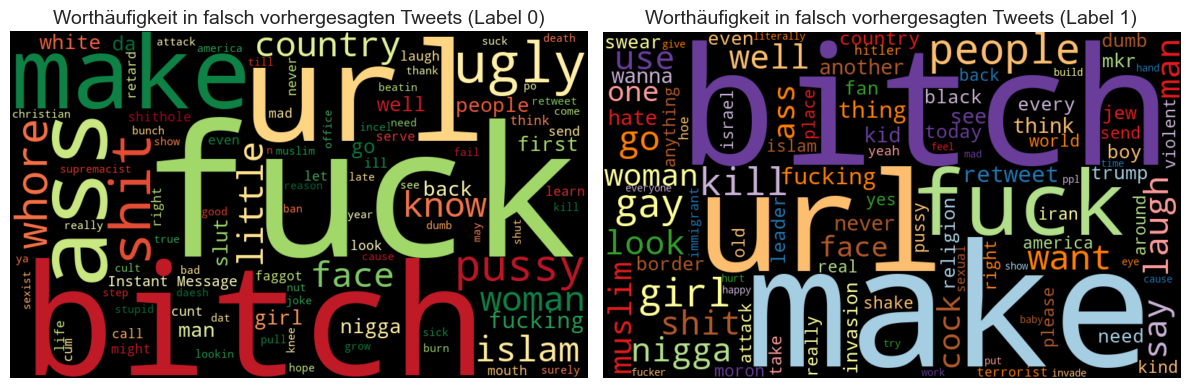

In [150]:
dataset_0_text = " ".join(merged_false[merged_false.label == 0]["tweet_cleaned"].tolist())
dataset_1_text = " ".join(merged_false[merged_false.label == 1]["tweet_cleaned"].tolist())

plt.figure(figsize=(12, 6))

# Subplot 1: Dataset 0
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='RdYlGn').generate(dataset_0_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 0, Modell 1)", fontsize=14)

# Subplot 2: Dataset 1
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='Paired').generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 1, Modell 0)", fontsize=14)


plt.tight_layout()
plt.show()

Beschreibung Wordclouds
- links: zeigt die Worthäufigkeiten von falsch vorhergesagten Tweets mit Label 0 (d.h., die Modelle haben 1 vorhergesagt)
    -
- rechts: zeigt die Worthäufigkeiten von falsch vorhergesagten Tweets mit Label 1 (d.h., die Modelle haben 0 vorhergesagt)
    -

In [153]:
merged_false[merged_false.label == 0]

,label,tweet,tweet_cleaned,zero_proba_hate,one_proba_hate,pred_hate,zero_proba_sent,one_proba_sent,pred_sent
2,0,Import shithole people with shithole culture a...,import shithole people shithole culture shitho...,0.033789,0.966211,1,0.148227,0.851773,1
4,0,This bitch bout to make me commit murder &#128...,bitch bout make commit murder,0.331382,0.668618,1,0.392702,0.607298,1
8,0,Israel can burn in hell gods people my ass,israel burn hell god people ass,0.177929,0.822071,1,0.067708,0.932292,1
10,0,@user Send her back Muslim traitor,send back muslim traitor,0.135382,0.864618,1,0.119968,0.880032,1
15,0,Islam is the greatest threat civilized countri...,islam great threat civilized country face sinc...,0.018990,0.981010,1,0.110199,0.889801,1
...,...,...,...,...,...,...,...,...,...
181,0,this is so fucked. why would ANYONE do this to...,fuck would anyone poor girl wanna fucken burn ...,0.107216,0.892784,1,0.180059,0.819941,1
184,0,Fucking pathetic incel virgins,fuck pathetic incel virgin,0.185098,0.814902,1,0.240436,0.759564,1
187,0,@user Kat is showing her true colours #mkr,kat show true colour mkr,0.166228,0.833772,1,0.054247,0.945753,1
188,0,Fuck off ya chubby racist. You look like a pos...,fuck ya chubby racist look like version chris ...,0.115992,0.884008,1,0.189413,0.810587,1


In [154]:
merged_false[merged_false.label == 1]

,label,tweet,tweet_cleaned,zero_proba_hate,one_proba_hate,pred_hate,zero_proba_sent,one_proba_sent,pred_sent
0,1,Iran is the enemy of the world.,iran enemy world,0.988325,0.011675,0,0.997765,0.002235,0
1,1,@user You are unbelievable! Those women don't ...,unbelievable woman hate america orange one hat...,0.880235,0.119765,0,0.500907,0.499093,0
3,1,"""Boycott this seditious, sickular Islamist. He...",""" boycott islamist sell halal product moody ji...",0.734977,0.265023,0,0.547168,0.452832,0
5,1,@user watch one u.s. #marine fearlessly take o...,watch one us take violent angry mob pro - pale...,0.999269,0.000731,0,0.998463,0.001537,0
6,1,Yes send them the fuck back and tell them to u...,yes send fuck back tell use fucking condom dam...,0.782379,0.217621,0,0.786635,0.213365,0
...,...,...,...,...,...,...,...,...,...
186,1,"Rot in hell yt devils. These ""immigrants"" are ...","rot hell YouTube devil "" immigrant ppl belong ...",0.937312,0.062688,0,0.984937,0.015063,0
189,1,When you surround yourself with people who are...,"surround people always "" ironic say shit like ...",0.982953,0.017047,0,0.871500,0.128500,0
190,1,RT @user: It's either Katie and Nikki or Kat a...,retweet either katie nikki kat andre go viewer...,0.995250,0.004750,0,0.952079,0.047921,0
192,1,"u/ologvinftw ""He got me,"" AIPAC said of u/olog...",""" get say boom add anti semitic repeat four ti...",0.837173,0.162827,0,0.960090,0.039910,0


Erkenntnisse
- Prüfung von einigen Tweets mit Label 1, welche nicht als 1 vorhergesagt wurden: sehr häufig kein Hate-Speech erkennbar => bedeutet, dass Modelle "richtig" vorhersagen und die Daten schlecht/falsch gelabelt sind
- Prüfung von einigen Tweets mit Label 0, welche nicht als 0 vorhergesagt wurden: enthalten Schlagworte, die auf Hate-Speech hindeuten